In [1]:
import keras
print(f"Keras: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow.keras.optimizers import RMSprop # may be skipped

from PIL import Image
import PIL
from pathlib import Path
from glob import glob
import os
from time import time


Keras: 2.15.0
Tensorflow: 2.15.0


In [2]:
class Dataset:

    """Creates a Dataset object, that processes source images and contains
       output training/validation tiles.

       This originates from, but is different to, Dataset class in furrybroccoli.
       In here we don't have paired images, only high-res images that will
       be used to generate high-res and low-res tiles.
        
        params
        ======
        
        folder name: <str> the folder where to look for the images
        tile_size: <int>: images will be sliced into tile_size × tile_size squares
        img_type: <str> the type (extension) of the images we're looking for in the target <folder_name>
        =====
        
        self.make_dataset(): processes the images contained in the <folder_name>
             to squares of <tile_size> pixels.
             
             produces
             ========
             self.hires_tiles_: <np.array> hires tiles (squares of <tile_size> dims)
             self.lores_tiles_: <np.array> lores tiles (squares of int(<tile_size> / 2) dims)
             
             When an image is split into tiles, each tile is split into
             R, G, B channels and added to the growing list of tiles.
             
             Each tile is converted to a <np.array>, values untouched (0-255)      
             
        
        self.shuffle_dataset(): shuffle all tiles (tile correspondences are maintained)
        
        
        """

    def __init__(self, folder_name, tile_size=28,
                 img_type="JPG"
                ):

        self.folder_name = folder_name
        self.tile_size = tile_size
        
        self.dataset_shuffled = False
        self.rgb_dataset_shuffled = False
        
        # loading image names from dataset directory ===
        # for Python < 3.10 with limited glob functionality
        self.basedir = Path(os.getcwd())
        os.chdir(folder_name)
        img_files = glob(f"*.{img_type}")
        img_files = [x for x in img_files if x.endswith(f".{img_type}")]
        self.pics_filenames = img_files
        os.chdir(self.basedir)

    
    def _load_pic(self, image_name, folder_name):

        """
        Assumes a subdirectory <folder name> containing the
        image <image_name> to load.

        params
        ======

        image_name: <str>
        folder_name: <str>
        """

        fullpath = Path(folder_name, image_name)
        picture = Image.open(fullpath)
        return picture
    

    def _crop_in_tiles(self, image, tile_size=28, shift=0):

        """
        This function crops an image in several tiles
        tile_size × tile_size squares, yielding a tile
        every iteration.

        If the input image is not a perfect multiple of
        a(tile_size) × b(tile_size), non-square tiles are NOT
        YIELDED.

        params
        ======

        image: a Pillow open image
        tile_size: <int> pixels; size of the tile side
        shift: <int>: the offset from 0,0 in pixels
        """

        assert isinstance(tile_size, int)
        assert isinstance(shift, int)

        width, height = image.size

        #calculate coordinates of every tile
        for x in range (0+shift, width, tile_size):
            if width - x < tile_size:
                continue

            for y in range (0+shift, height, tile_size):
                if height - y < tile_size:
                    continue

                # tile coord ===
                tile_coord = (
                    x, y, # upper left coords
                    x + tile_size, y + tile_size # lower right coords
                )

                tile = image.crop(tile_coord)
                yield tile
        

    def _split_into_channels(self, image, as_array=False):
        
        if not as_array:
            return [image.getchannel(x) for x in "RGB"]
        else:
            return [np.array(image.getchannel(x)) for x in "RGB"]


    def make_dataset(self):
        pics = (self._load_pic(x, self.folder_name) for x in self.pics_filenames)

        # these will store tile1_R, tile1_G, tile1_B, tile2_R, tile2_G, ..
        self.hires_tiles_ = []
        self.lores_tiles_ = []

        for hires in pics:
            tiles = self._crop_in_tiles(hires, tile_size=self.tile_size,)
            for tile in tiles:
                self.hires_tiles_.extend(self._split_into_channels(tile, as_array=True))
                self.lores_tiles_.extend(self._split_into_channels(tile, as_array=False))

        # Here we decide how to deal with the tiles (stored as individual <Image> objects)
        # stored in self.lores_tiles_
        # Strategy: we make each one with dimension int(tile_size / 2)
        # Image.BICUBIC is slower than Image.NEAREST but we're after the best
        # possible representation of hi-res data here
        ndim = int(self.tile_size / 2)
        self.lores_tiles_ = [x.resize((ndim, ndim), Image.BICUBIC) for x in self.lores_tiles_]
        self.lores_tiles_ = [np.array(x) for x in self.lores_tiles_] # matching type in self.hires_tiles_

        # final transform of each list into a np.array
        self.hires_tiles_ = np.array(self.hires_tiles_)
        self.lores_tiles_ = np.array(self.lores_tiles_)


    def shuffle_dataset(self):
        if hasattr(self, "hires_tiles_"):
            shuffler = np.random.permutation(len(self.hires_tiles_))
            self.hires_tiles_ = self.hires_tiles_[shuffler]
            self.lores_tiles_ = self.lores_tiles_[shuffler]
            
            self.dataset_shuffled = True
        else:
            print("Nothing to shuffle, yet. Run 'self.make_dataset()' to make one.")

In [45]:
class Denoiser():
    """ Works on PIL <Image> objects.
    
    Denoiser.denoise() returns a denoised image, based on the model and
    input parameters.

    Denoiser.adv_denoise() returns a denoised image, based on the model and
    input parameters, free from tiling artefacts (usually there is a visible
    artefact at each tile boundary, both horizontally and vertically).
    This is more expensive in computational time, but it allows to use smaller
    tiles which *dramatically* reduce the amount of RAM needed to process the
    entire image.
    This is usually ~4X slower than Denoiser.denoise().
    
    params
    ======
    
    image: an open PIL Image object
    model: a keras trained model object
    
    tile_size: <int> lenght, in pixel, of the square being denoised
        by the model. Higher values use higher amounts of RAM.
    
    """
    
    def __init__(self, image, model, tile_size=256, debug=False, verbose=True):
        self.image = image
        self.model = model
        self.tile_size = tile_size
        self.debug = debug
        self.verbose = verbose
        

    def _deb(self, *args, **kwargs):
        if self.debug:
            print(*args,**kwargs)

            
    def _say(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)

    # from Dataset class
    def _crop_in_tiles(self, image, tile_size=56, shift=0, asarray=True):

        """
        This generator function crops an image in several tiles
        tile_size × tile_size squares, yielding a tile
        every iteration.

        If the input image is not a perfect multiple of
        a(tile_size) × b(tile_size), non-square tiles are NOT
        YIELDED.

        params
        ======

        image: a Pillow open image
        tile_size: <int> pixels; size of the tile side
        shift: <int>: the offset from 0,0 in pixels
        
        yields
        ======
        
        A tile_size × tile_size np.array taken form the input image,
        but converted to float32 type and with values normalized from
        0 to 1
        """

        assert isinstance(tile_size, int)
        assert isinstance(shift, int)
        
        self._deb(f"debug: {tile_size} tile_size in _crop_in_tiles")

        width, height = image.size

        #calculate coordinates of every tile
        for x in range (0 + shift, width, tile_size):
            if width - x < tile_size:
                continue

            for y in range (0 + shift, height, tile_size):
                if height - y < tile_size:
                    continue

                # tile coord ===
                tile_coord = (
                    x, y, # upper left coords
                    x + tile_size, y + tile_size # lower right coords
                )

                tile = image.crop(tile_coord)

                if not asarray:
                    yield tile #yielding tile as image
                else:
                    yield np.array(tile).astype("float32") / 255
        
        
    def _predict_tiles_from_image(self, image, model, tile_size=56):
        """ This gives back the denoised <tiles>, according to the loaded <model>
        The model operates on multiple tiles at once. All tiles are shaped into a form
        that the model was trained for, then all put into a np.array container.
        This is the way the models expects the tiles for the prediction.

        NOTE: This function relies on crop_in_tiles() function.

        params
        ======

        image: a pillow Image object
        model: a keras trained model
        
        tile_size: <int> pixels. The model will operate and predict on a square with
            <tile_size> side. Higher values allocate higher amounts of RAM.
            
        returns
        ======
        
        A np.array containing all denoised (predicted) tiles
        """
        
        # all tiles need to be put into a list and reshaped to a form
        # the model is confortable with (x,x) to (x,x,1)
        
        self._deb(f"debug: {tile_size} tile_size in _predict_tiles_from_image")
        
        to_predict = [
            x.reshape(tile_size, tile_size, 1) for x in self._crop_in_tiles(image, tile_size)
        ]

        # the model expects an array of tiles, not a list of tiles
        to_predict = np.array(to_predict)

        return model.predict(to_predict)

    

    # The image needs to be an exact multiple of the <tile_size>
    # the model was trained with because tensorflow > 2.6.0
    # stubbornly refuses to give it a spin nonetheless (even if it works)
    def _add_extra_width(self, image, tile_size=28):
        """Returns an <image> that is compatible with tile_size, horizontally
        
        This is done by applying a vertical patch taken from the right
        side of the image.
        """
        
        width, height = image.size

        # check width
        # if (extra_width := width % tile_size) != 0: # Python 3.8+
        if width % tile_size != 0:
            extra_width = width % tile_size 
            # we need to add extra_width pixels to the image
            # we'll duplicate patches from the corner of the image
            # that we'll temporarily stick to it, then remove it when finished

            # first, we fill in the x axis (on the right) by applying a vertical patch
            # then, we fill the y axis (at the bottom) by applying a horiozntal patch

            horizontal_pixels_to_add = tile_size - extra_width
            left = width - horizontal_pixels_to_add
            upper = 0
            right = width
            lower = height

            horizontal_patch = image.crop((left, upper, right, lower))

            temp_img = np.concatenate([np.array(image), np.array(horizontal_patch)], axis=1)
            
            return Image.fromarray(temp_img)
        
        else:
            
            return image

        
    def _add_extra_height(self, image, tile_size=28):
        """Returns an <image> that is compatible with tile_size, vertically
        
        This is done by applying a horizontal patch taken from the bottom
        side of the image.
        """
        
        width, height = image.size
        
        # The image needs to be an exact multiple of the tile_size
        # the model was trained with because tensorflow > 2.6.0
        # stubbornly refuses to give it a spin nonetheless (even if it works)

        # check width
        #if (extra_height := height % tile_size) != 0:
        if height % tile_size != 0:
            extra_height = height % tile_size
            # we need to add extra_width pixels to the image
            # we'll duplicate patches from the corner of the image
            # that we'll temporarily stick to it, then remove it when finished

            # first, we fill in the x axis (on the right) by applying a vertical patch
            # then, we fill the y axis (at the bottom) by applying a horiozntal patch

            vertical_pixels_to_add = tile_size - extra_height
            left = 0
            upper = height - vertical_pixels_to_add
            right = width
            lower = height

            horizontal_patch = image.crop((left, upper, right, lower))

            temp_img = np.concatenate([np.array(image), np.array(horizontal_patch)], axis=0)
            
            return Image.fromarray(temp_img)

        else:
            
            return image


    def _image_rebuilder(self, image, model, tile_size=56):
        """ Takes as input a monochromatic (single-channel) image,
        returns a denoised monochromatic image.
        
        params
        ======
        
        image: a PIL monochromatic image. ONLY ONE channel is supported
        model: a trained keras model to denoise the input image
        
        tile_size: <int> pixels of a square side to process at once.
            This is not related to the tile_size the model has been built
            with, but dictates how big is the square the model is fed with
            for denoising. The bigger this parameter, the more RAM is needed
            to perform the denoising.
            This cannot be higher than the image phisical size.
            
        returns
        =======
        A monochromatic, denoised PIL.Image object
        
        """

        # I was initially wondering to manage the channel splitting here,
        # but as the model is currently working on monochromatic images,
        # and will eventually manage the three channels with three different
        # models (again, with one channel per image), this stub of implementation
        # is not necessary anymore.
        # TODO: clear the clutter
        channels = [image]

        width, height = channels[0].size #all three channels have the same size
        self._say(f"width: {width}; height: {height}")

        # TODO
        # for now, we support only exact multiples of tile_size
        tile_width = int(width / tile_size)
        tile_height = int(height / tile_size)

        self._say(f"Image multiple of {tile_width}×{tile_height} integer tiles.")

        for i, channel in enumerate(channels):
            
            # next line useless if we just process one channel
            #self._say(f"Processing channel {i + 1} of {len(channels)}")
            self._deb(f"debug: {tile_size} tile_size in _image_rebuilder")
            
            pred_tiles = [self._predict_tiles_from_image(channel, model, tile_size=tile_size)]

            self._deb(f"Predicted tiles length: {len(pred_tiles[0])}")

            # now we need to rebuild a numpy array based on the tile_width*tile_height original geometry        
            gen = (x for x in pred_tiles[0])

            # the final assembly is very fast ===
            returnimage = []

            #for i in range(tile_height):
            #    row_tiles = next(gen)
            #    for j in range(tile_width - 1):
            #        next_tile = next(gen)
            #        row_tiles = np.concatenate((row_tiles, next_tile), axis=1)
            #    returnimage.append(row_tiles)
            #
            #returnimage = np.array(returnimage)
            #returnimage = np.vstack(returnimage)

            for i in range(tile_width):
                row_tiles = next(gen)
                for j in range(tile_height - 1):
                    next_tile = next(gen)
                    row_tiles = np.concatenate((row_tiles, next_tile), axis=0)
                returnimage.append(row_tiles)

            returnimage = np.array(returnimage)
            returnimage = np.hstack(returnimage)

            # from array (0-1) to Image (0-255)
            returnimage = np.uint8(returnimage * 255)
            
            # discarding the last dimension
            return Image.fromarray(returnimage[:,:,0])   


    def denoise(self, show=True, hide_extra_text=False, multichannel=False):
        #This does NOT detect multichannel mode. It's done in adv_denoise()
        
        if multichannel:

            self._say("Denoising red channel..")
            denoised_r = self._image_rebuilder(
                self.image.getchannel("R"), self.model[0], self.tile_size
            )
            
            self._say("Denoising green channel..")
            denoised_g = self._image_rebuilder(
                self.image.getchannel("G"), self.model[1], self.tile_size
            )
            
            self._say("Denoising blue channel..")
            denoised_b = self._image_rebuilder(
                self.image.getchannel("B"), self.model[2], self.tile_size
            )
            
            rgb = Image.merge("RGB",(denoised_r, denoised_g, denoised_b))
            
            self.denoised_ = rgb
            del denoised_r, denoised_g, denoised_b
            
            if not hide_extra_text: # useless if called whithin self.adv_denoise()
                self._say("Denoised image in 'denoised_' attribute.")
            
            if show:
                return rgb

        else:

            self._say("Denoising red channel..")
            denoised_r = self._image_rebuilder(
                self.image.getchannel("R"), self.model, self.tile_size
            )
            
            self._say("Denoising green channel..")
            denoised_g = self._image_rebuilder(
                self.image.getchannel("G"), self.model, self.tile_size
            )
            
            self._say("Denoising blue channel..")
            denoised_b = self._image_rebuilder(
                self.image.getchannel("B"), self.model, self.tile_size
            )
            
            rgb = Image.merge("RGB",(denoised_r, denoised_g, denoised_b))
            
            self.denoised_ = rgb
            del denoised_r, denoised_g, denoised_b
            
            if not hide_extra_text: # useless if called whithin self.adv_denoise()
                self._say("Denoised image in 'denoised_' attribute.")
            
            if show:
                return rgb



    # TODO: replace adv_denoise with this one when finished
    def adv_denoise(self, show=True, delta=10):
        """
        This function has been developed from adv_denoise().
        
        It can either denoise an image with one model for all channels,
        or using three different models to denosise red, green and blue channels
        independently.

        This function runs a 4-step denoising process that takes care to remove all
        bordering artefacts.
        This makes it possibile to use a small tile size for denoising and still
        get an artefact-free final image

        <delta>: the number of pixels to make transparent at t intersections
        """
        
        # Preparing the transparency masks

        # vertical stripes (operazione 1)
        def make_vertical_stripes(n_tiles, as_image=True, final=False):
            arrays = []

            arrays.append(np.ones((height, t - halfdelta), dtype=np.uint8)*255)
            arrays.append(np.zeros((height, delta), dtype=np.uint8))

            for _ in range(n_tiles - 2):
                arrays.append(np.ones((height, t - delta), dtype=np.uint8)*255)
                arrays.append(np.zeros((height, delta), dtype=np.uint8))        

            arrays.append(np.ones((height, t - delta), dtype=np.uint8)*255)

            if final:
                arrays.append(np.ones((height, halfdelta), dtype=np.uint8)*255) # modified
            else:
                arrays.append(np.zeros((height, halfdelta), dtype=np.uint8)) # modified

            vertical_stripes = np.concatenate(arrays, axis=1)

            if not as_image:
                return vertical_stripes
            else:
                return Image.fromarray(vertical_stripes)


        # horizontal stripes (operazione 4)
        def make_horizontal_stripes(n_tiles, as_image=True, final=False):
            arrays = []

            arrays.append(np.ones((t - halfdelta, width), dtype=np.uint8)*255)
            arrays.append(np.zeros((delta, width), dtype=np.uint8))

            for _ in range(n_tiles - 2):
                arrays.append(np.ones((t - delta, width), dtype=np.uint8)*255)
                arrays.append(np.zeros((delta, width), dtype=np.uint8))        

            arrays.append(np.ones((t - delta, width), dtype=np.uint8)*255)

            if final:
                arrays.append(np.ones((halfdelta, width), dtype=np.uint8)*255) # modified
            else:
                arrays.append(np.zeros((halfdelta, width), dtype=np.uint8))

            horizontal_stripes = np.concatenate(arrays, axis=0)

            if not as_image:
                return horizontal_stripes
            else:
                return Image.fromarray(horizontal_stripes)

        # ---
        # crops, black bars

        def make_black_img(hsize, vsize):
            channels = [np.zeros((vsize, hsize), dtype=np.uint8) for _ in range(3)]
            channels = [Image.fromarray(x) for x in channels]

            return Image.merge("RGB", channels)

        # ---

        def make_left_crop(image, amount, as_image=True):
            # amount is usually half_t

            cropshift = image.crop((amount, 0, width, image.height)) # (left, upper, right, lower)

            if not as_image:
                return np.array(cropshift)
            else:
                return cropshift


        def make_right_crop(image, amount, as_image=True):
            # amount is usually half_t

            cropshift = image.crop((0, 0, width - amount, image.height)) # (left, upper, right, lower)

            if not as_image:
                return np.array(cropshift)
            else:
                return cropshift


        def apply_left_bar(image, amount, as_image=True):
            # amount is usually half_t

            leftbar = make_black_img(amount, image.height)
            shift = np.concatenate((np.array(leftbar), np.array(image)), axis=1)

            if not as_image:
                return shift
            else:
                return Image.fromarray(shift)


        def apply_right_bar(image, amount, as_image=True):
            # amount is usually half_t

            rightbar = make_black_img(amount, image.height)

            try:
                shift = np.concatenate((np.array(image), np.array(rightbar)), axis=1)
            except:
                print("Something went wrong.")
                print(f"Image array shape: {np.array(image).shape}; bar: {np.array(rightbar).shape}")
                print("Are you trying to process a base image with alpha channel?")
                raise

            if not as_image:
                return shift
            else:
                return Image.fromarray(shift)

        # ---
        
        def make_top_crop(image, amount, as_image=True):
            # amount is usually half_t

            cropshift = image.crop((0, amount, image.width, image.height)) # (left, upper, right, lower)

            if not as_image:
                return np.array(cropshift)
            else:
                return cropshift


        def make_bottom_crop(image, amount, as_image=True):
            # amount is usually half_t

            cropshift = image.crop((0, 0, image.width, image.height - amount)) # (left, upper, right, lower)

            if not as_image:
                return np.array(cropshift)
            else:
                return cropshift


        def apply_top_bar(image, amount, as_image=True):
            # amount is usually half_t

            topbar = make_black_img(image.width, amount)
            shift = np.concatenate((np.array(topbar), np.array(image)), axis=0)

            if not as_image:
                return shift
            else:
                return Image.fromarray(shift)


        def apply_bottom_bar(image, amount, as_image=True):
            # amount is usually half_t

            bottombar = make_black_img(image.width, amount)
            shift = np.concatenate((np.array(image), np.array(bottombar)), axis=0)

            if not as_image:
                return shift
            else:
                return Image.fromarray(shift)

        # ---
        
        def apply_mask(image, mask):

            #assert image.size == mask.size TODO: FIX: this was OK for denoising, not upscaling
            r, g, b = (image.getchannel(x) for x in "RGB")

            rgba = Image.merge("RGBA",(r, g, b, mask))

            return rgba


        def make_fixing_mask(n_tiles, as_image=True):
            """This fixes the bottom artifact in the downshift 
            image due to the denoising of black bars.

            n_tiles is the number of HORIZONTAL TILES
            """
            arrays = []
            # 0 == opaque; 255 == transparent
            # axis=0 - stack vertically
            # axis=1 - stack horizontally

            arrays.append(np.zeros((height - halfdelta, width), dtype=np.uint8))

            # bottom stripe: make this by staking stuff horizontally
            temparray = []
            temparray.append(np.ones((halfdelta, t - halfdelta), dtype=np.uint8)*255)
            for _ in range(n_tiles - 2):
                temparray.append(np.zeros((halfdelta, delta), dtype=np.uint8))
                temparray.append(np.ones((halfdelta, t - delta), dtype=np.uint8)*255)

            temparray.append(np.zeros((halfdelta, delta), dtype=np.uint8))
            temparray.append(np.ones((halfdelta, t - halfdelta), dtype=np.uint8)*255) 

            bottom_strip = np.concatenate(temparray, axis=1)

            arrays.append(bottom_strip)

            final_mask = np.concatenate(arrays, axis=0)

            if not as_image:
                return final_mask
            else:
                return Image.fromarray(final_mask)
            
        # ---
        # Let's get started
        # ---

        # INPUT
        base = self.image.convert("RGB") # don't need the eventual alpha channel
        model = self.model # already a model object OR an iterable with three models
                           # is this necessary? Nope, but it's shorter than self.model

        """ # TODO: remove new Keras-incompatible code: keras.engine.sequential
        if isinstance(
            self.model,
            #keras.engine.sequential.Sequential #TODO: not compatible with current keras version
        ):
            multichannel = False
        else:
            if len(model) != 3:
                msg = "Error. <model> must contain exactly 3 models, one for each R, G, B channel."
                raise TypeError(msg)

            try:
                assert isinstance(model[0], keras.engine.sequential.Sequential)
                assert isinstance(model[1], keras.engine.sequential.Sequential)
                assert isinstance(model[2], keras.engine.sequential.Sequential)
            except AssertionError:
                print("Check the output: something's wrong with some model.")
                raise
            multichannel = True
            self._say("Multichannel mode: denoising channels with separate models.")

        """
        multichannel = False # TODO: reimplement multichannel model check (new keras incompatibilities)
        
        orig_width, orig_height = self.image.size
        # self._deb(f"{orig_width=}, {orig_height=}") # Python 3.8+

        try:
            assert orig_width  % self.tile_size == 0
            assert orig_height % self.tile_size == 0
            extra_pixels = False # signals the final processing to leave the image untouched
        except AssertionError: # adding an extra bit to avoid keras complaints
            base = self._add_extra_width(base, self.tile_size)
            base = self._add_extra_height(base, self.tile_size)
            extra_pixels = True

        width, height = base.size
        # self._deb(f"{width=}, {height=}") # Python 3.8+

        # TODO: make these selectable
        t = self.tile_size                # tile size (tile is t×t size)
        half_t = t // 2                   # half the tile size
        n_horizontal_tiles = width // t   # choose reasonably so that no pixel is lost
        n_vertical_tiles = height // t    # choose reasonably so that no pixel is lost
        #delta = 10                        # the number of pixels to make transparent at t intersections
        halfdelta = delta // 2            # the number of delta pixels in a tile

        self._say(f"Image properties: {orig_width}×{orig_height} pixels")
        if extra_pixels:
            self._say("We adjusted the image size to be compatible with the model.")
            self._say("(Don't worry, the added patches will be sliced off at the end).")
            self._say(f"Working on: {width}×{height} pixels")
        self._say(f"Tile size: {t}; half tile size: {half_t}; {n_horizontal_tiles}×{n_vertical_tiles} total tiles")
        self._say(f"Intersection Δ: {delta}; half Δ: {halfdelta}")

        # transparency masks
        vertical_mask = make_vertical_stripes(n_horizontal_tiles) # counter-intuitive
        horizontal_mask  = make_horizontal_stripes(n_vertical_tiles) # counter-intuitive

        # horizontal processing
        t0 = time()
        self._say("Pass 1/4")

        lc = make_left_crop(base, half_t)
        lc_rightbar = apply_right_bar(lc, half_t)
        rightshift = Denoiser(
            lc_rightbar, model,
            tile_size=self.tile_size, verbose=self.verbose
        )
        rightshift.denoise(show=False, hide_extra_text=True, multichannel=multichannel)
        rc = make_right_crop(rightshift.denoised_, half_t)
        rightshift = apply_left_bar(rc, half_t)

        t0_final = time() - t0
        self._say(f"Complete. {round(t0_final, 1)} seconds elapsed.")

        # vertical processing
        t1 = time()
        self._say("Pass 2/4")

        tc = make_top_crop(base, half_t)
        lc_bottombar = apply_bottom_bar(tc, half_t)
        downshift = Denoiser(
            lc_bottombar, model,
            tile_size=self.tile_size, verbose=self.verbose
        )
        downshift.denoise(show=False, hide_extra_text=True, multichannel=multichannel)
        bc = make_bottom_crop(downshift.denoised_, half_t)
        downshift = apply_top_bar(bc, half_t)

        t1_final = time() - t1
        self._say(f"Complete. {round(t1_final, 1)} seconds elapsed.")

        # diagonal processing
        t2 = time()
        self._say("Pass 3/4")
        diag = make_right_crop(base, half_t)
        diag = make_bottom_crop(diag, half_t)
        diag = make_left_crop(diag, half_t)
        diag = make_top_crop(diag, half_t)
        diag_d = Denoiser(
            diag, model,
            tile_size=self.tile_size, verbose=self.verbose
        )
        diag_d.denoise(show=False, hide_extra_text=True, multichannel=multichannel)
        diagshift = diag_d.denoised_
        diagshift = apply_right_bar(diagshift, half_t)
        diagshift = apply_bottom_bar(diagshift, half_t)
        diagshift = apply_top_bar(diagshift, half_t)
        diagshift = apply_left_bar(diagshift, half_t)

        t2_final = time() -t2
        self._say(f"Complete. {round(t2_final, 1)} seconds elapsed.")


        # Denoising the base image
        t3 = time()
        self._say("Pass 4/4")
        base_d = Denoiser(
            base, model,
            tile_size=self.tile_size, verbose=self.verbose
        )
        base_d.denoise(show=False, hide_extra_text=True, multichannel=multichannel)


        t3_final = time() -t3
        self._say(f"Complete. {round(t3_final, 1)} seconds elapsed.")


        # RECONSTRUCTION STEPS
        t4 = time()
        self._say("Reconstructing the denoised image..")
        # Operazione 1: rimozione delle intersezioni verticali da immagine base
        step1 = apply_mask(base_d.denoised_, vertical_mask)
        # Operazione 2: denoise dell'immagine spostata verso dx di 32 px (rappresentata in arancione):
        step2 = rightshift
        # Operazione 3: merge
        step3 = Image.alpha_composite(step2.convert("RGBA"), step1)
        # Operazione 4: rimozione delle intersezioni orizzontali da immagine base
        step4 = apply_mask(base_d.denoised_, horizontal_mask)
        # Operazione 5: denoise dell'immagine spostata verso il basso di 32 px (rappresentata in verde):
        step5 = downshift.copy()
        # Operazione 6: merge
        step6 = Image.alpha_composite(step5.convert("RGBA"), step4)
        # Operazione 7: denoise dell'immagine spostata verso dx e verso il basso di 32 px (rappresentata in rosso):
        step7 = diagshift.copy()

        final_vertical_mask = make_vertical_stripes(n_horizontal_tiles, final=True) # counter-intuitive
        final_horizontal_mask  = make_horizontal_stripes(n_vertical_tiles, final=True) # counter-intuitive

        # Operazione 8: rimozione delle intersezioni orizzontali dall'immagine da operazione 3:
        step8 = apply_mask(step3, final_horizontal_mask)
        # Operazione 9: rimozione delle intersezioni verticali dall'immagine da operazione 6:
        step9 = apply_mask(step6, final_vertical_mask)
        # Operazione 10: merge delle immagini da operazioni 7, 8 e 9:
        step10 = Image.alpha_composite(step8, step9)
        step10 = Image.alpha_composite(step7.convert("RGBA"), step10)

        # Operazione 11: applicazione maschera a step 10
        fixmask = make_fixing_mask(n_horizontal_tiles)
        step11 = apply_mask(base_d.denoised_, fixmask)

        # Operazione 12: sostituzione delle strip da immagine base denoised
        # dentro immagine de-tiled
        step12 = Image.alpha_composite(step10, step11)

        if extra_pixels:
            self._say("Recropping the denoised image back to the original size.")
            right, lower = self.image.size
            step12 = step12.crop((0, 0, right, lower))

        t4_final = time() -t4
        self._say(f"Complete. {round(t4_final, 1)} seconds elapsed.")

        tot_time = t0_final + t1_final + t2_final + t3_final + t4_final
        self._say(f"Total processing time: {round(tot_time, 1)} seconds.")
        
        self.detiled_ = step12.copy()
        self._say("Denoised image in 'detiled_' attribute.")
        
        # TODO anything to delete? 
        
        if show:
            return self.detiled_


# DATA PREPPING #
# ===============

class DataFeed():
    """Prepping the array takes an insane amount of RAM. In the path to
    the total conversion to generators, I'm for now using a generator here
    to bridge between the still-manageable, feature-rich (such as "dataset.shuffle()")
    Dataset objects and the vectors that the model needs.

    Taking one step further, image_width and image_height are both
    replaced by tile_size, as we're always using perfect squares.
    """

    def __init__(self, array, batch_size=128, tile_size=28, astype="float32"):
        self.array = array
        self.batch_size = batch_size
        self.tile_size = tile_size
        self.astype = astype
    
    def __iter__(self):
        for i in range(0, len(self.array), self.batch_size):

            if K.image_data_format() == 'channels_first':
                array_slice = self.array[i:i + self.batch_size]
                array_slice = array_slice.reshape(
                    array_slice.shape[0], 1, self.tile_size, self.tile_size
                ).astype(self.astype)
            else: # "channels_last"
                array_slice = self.array[i:i + self.batch_size]
                array_slice = array_slice.reshape(
                    array_slice.shape[0], self.tile_size, self.tile_size, 1
                ).astype(self.astype)
          
            yield array_slice / 255 # Normalize data (0-255 to 0-1)

    def __len__(self):
        return len(self.array)

In [3]:
d = Dataset("dataset", tile_size=56, img_type="jpg")

In [4]:
d.make_dataset()
d.shuffle_dataset()

In [5]:
len(d.lores_tiles_), len(d.hires_tiles_), 

(5562, 5562)

In [6]:
d.hires_tiles_.__sizeof__(), d.lores_tiles_.__sizeof__(), 

(17442576, 4360752)

In [7]:
# trying to adapt the model from here:
# source: https://www.machinecurve.com/index.php/2019/12/20/building-an-image-denoiser-with-a-keras-autoencoder-neural-network/
# thing is we now have differently-shaped input and output tiles.

In [8]:
# Model configuration

hires_width, hires_height = 56, 56
lores_width, lores_height = 28, 28
batch_size = 150
no_epochs = 10 # 50
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0

In [9]:
def prep_array(array, img_width, img_height):
    
    """Preps an input array for the keras model. Adapted from source:

    Reshape data based on channels first / channels last strategy.
    This is dependent on whether you use TF, Theano or CNTK as backend.
    Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    """
    
    if K.image_data_format() == 'channels_first':
        array = array.reshape(array.shape[0], 1, img_width, img_height)
    else: #"channels_last"
        array = array.reshape(array.shape[0], img_width, img_height, 1)

    array = array.astype('float32')
    return array / 255 # Normalize data (0-255 to 0-1)


def get_hires_input_shape():

    """Adapted from source:
    
    # Reshape data based on channels first / channels last strategy.
    # This is dependent on whether you use TF, Theano or CNTK as backend.
    # Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py"""
    
    if K.image_data_format() == 'channels_first':
        return (1, hires_width, hires_height)
    else: #"channels_last"
        return (hires_width, hires_height, 1)


def get_lores_input_shape():

    """Adapted from source:
    
    # Reshape data based on channels first / channels last strategy.
    # This is dependent on whether you use TF, Theano or CNTK as backend.
    # Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py"""
    
    if K.image_data_format() == 'channels_first':
        return (1, lores_width, lores_height)
    else: #"channels_last"
        return (lores_width, lores_height, 1)

In [10]:
print("Working with these shapes:")
get_lores_input_shape(), get_hires_input_shape()

Working with these shapes:


((28, 28, 1), (56, 56, 1))

In [11]:
# input dataset
#==============
input_lores = prep_array(d.lores_tiles_, 28, 28)
input_hires = prep_array(d.hires_tiles_, 56, 56)

print(f"Total tiles: {len(input_lores)}")

Total tiles: 5562


In [12]:
# Create the model # unchanged from the tutorial, even if we now have 56*56 px tiles
try:
    del model
except:
    pass

model = Sequential()

model.add(Conv2D
          (64,
           kernel_size=(3, 3),
           kernel_constraint=max_norm(max_norm_value),
           activation='relu',
           kernel_initializer='he_uniform',
           input_shape=get_lores_input_shape()
          )
         )

model.add(Conv2D
          (32,
           kernel_size=(3, 3),
           kernel_constraint=max_norm(max_norm_value),
           activation='relu',
           kernel_initializer='he_uniform',
          )
         )

model.add(Conv2DTranspose
          (32,
           kernel_size=(3,3),
           kernel_constraint=max_norm(max_norm_value),
           activation='relu',
           kernel_initializer='he_uniform'
          )
         )

model.add(Conv2DTranspose
          (64,
           kernel_size=(3,3),
           kernel_constraint=max_norm(max_norm_value),
           activation='relu',
           kernel_initializer='he_uniform',
          )
         )

model.add(Conv2DTranspose
          (128,
           kernel_size=(3,3),
           kernel_constraint=max_norm(max_norm_value),
           activation='relu',
           kernel_initializer='he_uniform',
           strides=2, padding="same",
          )
         )

model.add(Conv2D
          (1,
           kernel_size=(3, 3),
           kernel_constraint=max_norm(max_norm_value),
           activation='sigmoid',
           padding='same',
          )
         )

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 26, 26, 32)        9248      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        18496     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 56, 56, 128)       73856     
 Transpose)                                                      
                                                       

In [13]:
#Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(input_lores, input_hires,
          epochs=no_epochs, #number of epochs
          batch_size=batch_size,
          validation_split=validation_split,
          shuffle=True,
)


Epoch 1/10

30/30 [==============================] - 15s 442ms/step - loss: 0.6583 - val_loss: 0.6276
Epoch 2/10
30/30 [==============================] - 16s 536ms/step - loss: 0.5293 - val_loss: 0.4864
Epoch 3/10
30/30 [==============================] - 17s 578ms/step - loss: 0.4867 - val_loss: 0.4809
Epoch 4/10
30/30 [==============================] - 18s 600ms/step - loss: 0.4844 - val_loss: 0.4797
Epoch 5/10
30/30 [==============================] - 18s 604ms/step - loss: 0.4836 - val_loss: 0.4793
Epoch 6/10
30/30 [==============================] - 18s 592ms/step - loss: 0.4831 - val_loss: 0.4790
Epoch 7/10
30/30 [==============================] - 18s 592ms/step - loss: 0.4831 - val_loss: 0.4789
Epoch 8/10
30/30 [==============================] - 18s 613ms/step - loss: 0.4827 - val_loss: 0.4787
Epoch 9/10
30/30 [==============================] - 18s 603ms/step - loss: 0.4827 - val_loss: 0.4791
Epoch 10/10
30/30 [==============================] - 18s 603ms/step - loss: 0.4826 - val_

In [14]:
model.save("moonscale model 64_32_32_64_128 relu binary crossentropy")

INFO:tensorflow:Assets written to: moonscale model 64_32_32_64_128 relu binary crossentropy\assets


INFO:tensorflow:Assets written to: moonscale model 64_32_32_64_128 relu binary crossentropy\assets


# Test

In [64]:
image = Image.open("test_images/test1.jpg")
print(image.size)
#model = keras.models.load_model("model_56px_neuralnet_vanilla")

up = Denoiser(
    image = image,
    model = model,
    tile_size = 28*24 # see below for details
)

(672, 672)


Denoising red channel..
width: 672; height: 672
Image multiple of 1×1 integer tiles.
1/1 [==============================] - 0s 493ms/step
Denoising green channel..
width: 672; height: 672
Image multiple of 1×1 integer tiles.
1/1 [==============================] - 0s 496ms/step
Denoising blue channel..
width: 672; height: 672
Image multiple of 1×1 integer tiles.
1/1 [==============================] - 1s 535ms/step
Denoised image in 'denoised_' attribute.


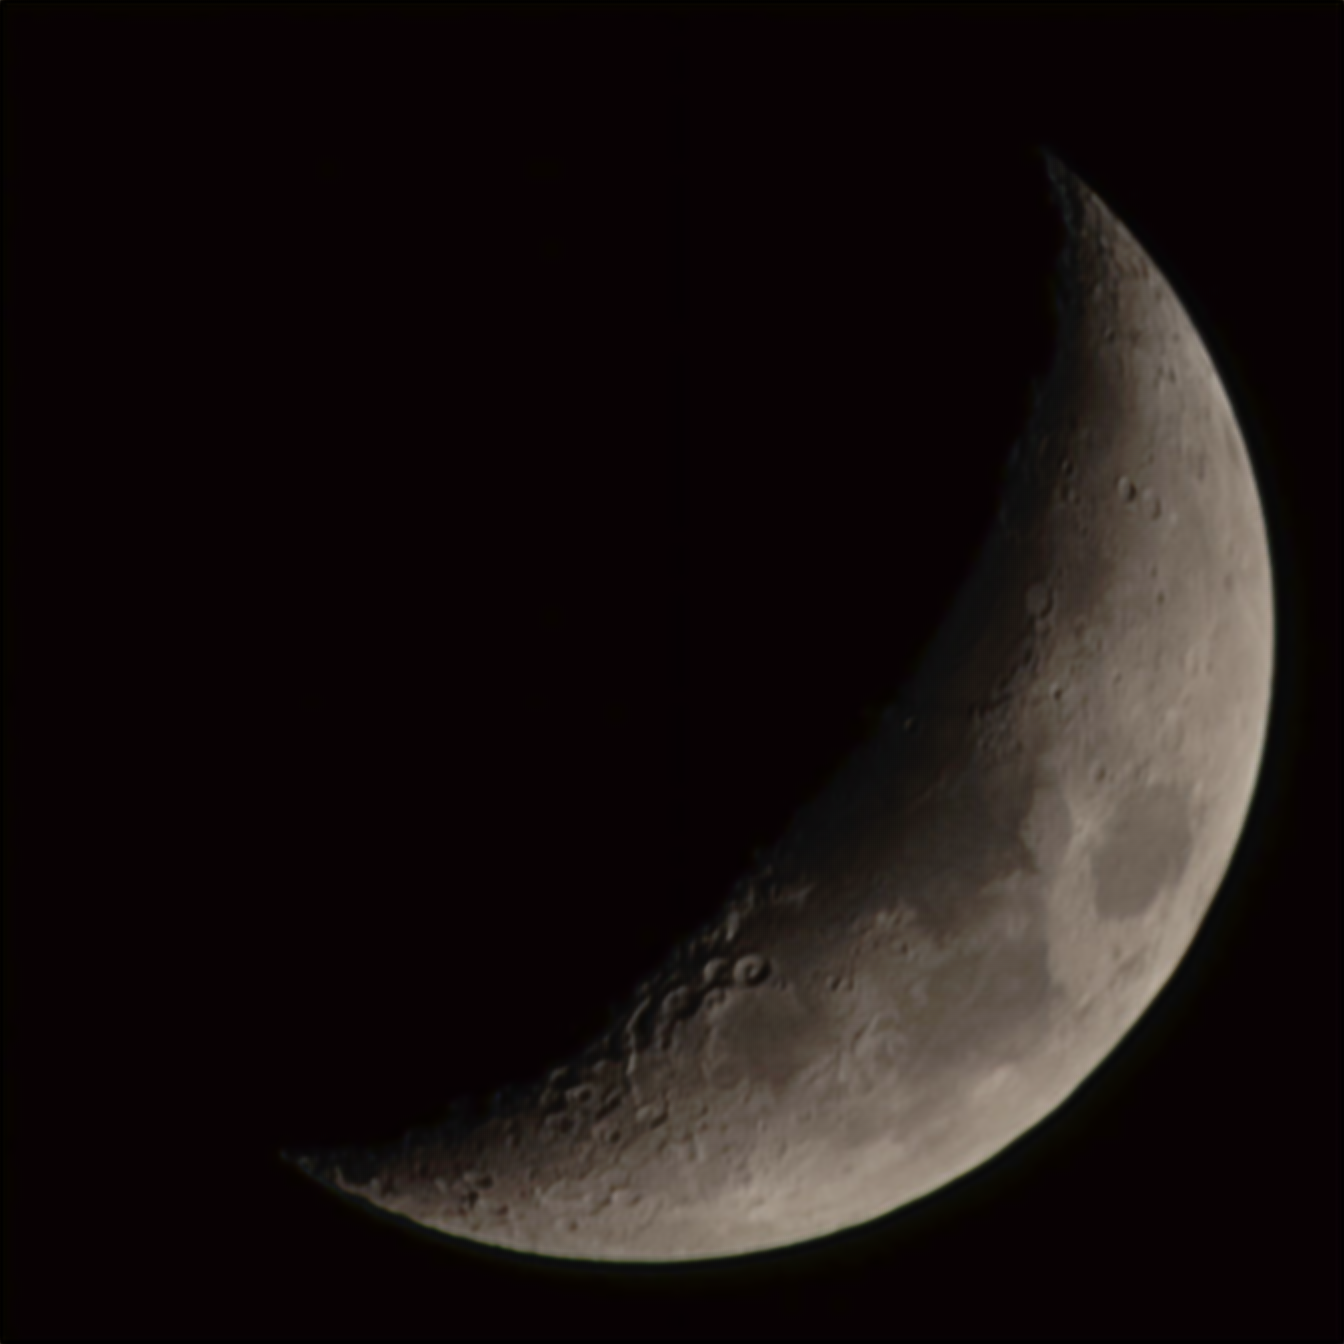

In [65]:
up.denoise()

In [66]:
up.denoised_.save("out.png")